# Artist identification

This notebook outlines a process for automatically identifying artist names from text data. We use a powerful technique called Named Entity Recognition (NER) to find mentions of people. The notebook is divided into several key steps:

1.  **Setup and Data Loading**: We'll import the necessary tools and load our dataset of book reviews.
2.  **Loading the NER Model**: We'll load a pre-trained AI model specialized in identifying entities like names, places, and organizations.
3.  **Post-Processing Logic**: We'll define a custom function to clean up the model's output, specifically to merge parts of names that the model might have separated (e.g., "George" and "Orwell").
4.  **Analysis and Visualization**: We'll run the model on a sample of our data, display the results in a readable format, and create a plot to understand the model's confidence in its predictions.

### 1. Setup and Data Loading
Here, we import the libraries we need for data handling (`pandas`), plotting (`matplotlib`), text formatting (`textwrap`), and working with AI models (`datasets`, `transformers`). We then specify the location of our cleaned dataset and load it into memory.

In [2]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations
import textwrap  # For formatting text output neatly
from datasets import load_dataset  # For loading datasets from various sources
from transformers import AutoTokenizer, AutoModelForTokenClassification  # Core components from Hugging Face
from transformers import pipeline  # A high-level helper for using models easily

In [3]:
# Define the file and folder paths for the dataset
file = 'Books_cleaned.csv'
folder = './Data_processed'

In [4]:
# Load the dataset from the specified CSV file
dataset = load_dataset("csv", data_files=folder + '/' + file)
# Print a summary of the loaded dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Author', 'Title', 'Publication', 'Date', 'Place', 'Full_text', 'URL', 'Cleaned_text', 'similarity_score'],
        num_rows: 2283
    })
})


### 2. Loading the NER Model
We are using a pre-trained model called `dslim/bert-large-NER`. This model has been trained on a vast amount of text and is skilled at recognizing entities. We load the model and its corresponding "tokenizer" (which prepares the text for the model). We then wrap them in a `pipeline` for easy use and test it on a simple example sentence.

In [5]:
# Load the tokenizer for the pre-trained NER model
# The tokenizer converts text into a format the model can understand (tokens).
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")

In [6]:
# Load the pre-trained NER model itself
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

# Create a NER pipeline, which simplifies the process of using the model for predictions.
# "aggregation_strategy" groups word pieces into single entities (e.g., "Wolf" + "gang" -> "Wolfgang").
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [7]:
# Define an example sentence to test the pipeline
example = "My name is Wolfgang and I live in Berlin"

# Run the NER pipeline on the example text
ner_results = nlp(example)

# Print the results to see what the model identified
print("Example Text:")
print(example)
print("Named Entity Recognition Results:")

# Loop through each entity found and print its details
for result in ner_results:
    print("Entity: ", result['entity_group'])  # The type of entity (e.g., PER for Person)
    print("Score: ", result['score'])        # The model's confidence in the prediction
    print("Word: ", result['word'])          # The actual word identified

Example Text:
My name is Wolfgang and I live in Berlin
Named Entity Recognition Results:
Entity:  PER
Score:  0.9971501
Word:  Wolfgang
Entity:  LOC
Score:  0.9986046
Word:  Berlin


### 3. Post-Processing and Display Functions
The NER model is good, but not perfect. Sometimes it splits a single name into multiple parts (e.g., identifying "W." and "H." and "Auden" as separate people). The `merge_author_entities` function contains logic to intelligently stitch these fragments back together.

The `display_comparison_flexible` function is a helper tool designed to print the original text, the raw model output, and our cleaned-up results side-by-side for easy comparison.

In [9]:
def merge_author_entities(ner_results, text):
    """
    Merges fragmented PER entities from a NER model's output into
    more complete author names.

    Args:
        ner_results (list): The raw output from the NER pipeline.
        text (str): The original text that was analyzed. This is used
                    to check for conjunctions between names.

    Returns:
        list: A new list of entities with fragmented authors merged.
    """
    if not ner_results:
        return []

    merged_results = []
    i = 0
    while i < len(ner_results):
        current_entity = ner_results[i]

        # Only try to merge if it's a Person entity
        if current_entity['entity_group'] == 'PER' and i + 1 < len(ner_results):
            next_entity = ner_results[i+1]
            
            # --- MERGING LOGIC ---
            # Check if the next entity is also a Person
            if next_entity['entity_group'] == 'PER':
                # Get the text between the two entities
                start = current_entity['end']
                end = next_entity['start']
                text_between = text[start:end]

                # Condition 1: Merge if separated by "and", "&", or just a space
                if text_between.strip() in ['and', '&', '']:
                    # Combine the words and scores
                    new_word = current_entity['word'] + text_between + next_entity['word']
                    new_score = (current_entity['score'] + next_entity['score']) / 2

                    # Create a new merged entity
                    merged_entity = {
                        'entity_group': 'PER',
                        'word': new_word.replace(" ##", ""), # Clean up sub-word tokens
                        'score': new_score,
                        'start': current_entity['start'],
                        'end': next_entity['end']
                    }
                    
                    # Replace the current entity with the new merged one
                    current_entity = merged_entity
                    i += 1 # Skip the next entity since we've merged it
                    
                # Condition 2: Merge single initials (e.g., "W." and "H.")
                elif current_entity['word'].endswith('.') and len(current_entity['word']) <= 3 and text_between.strip() == '':
                    new_word = current_entity['word'] + " " + next_entity['word']
                    new_score = (current_entity['score'] + next_entity['score']) / 2
                    
                    merged_entity = {
                        'entity_group': 'PER',
                        'word': new_word.replace(" ##", ""),
                        'score': new_score,
                        'start': current_entity['start'],
                        'end': next_entity['end']
                    }
                    
                    current_entity = merged_entity
                    i += 1

        merged_results.append(current_entity)
        i += 1
        
    # We may still have single initials or other fragments.
    # This final filter helps remove noise by keeping only entities tagged as PER
    # and longer than a single character (unless it's a known initial pattern).
    final_results = [
        ent for ent in merged_results 
        if ent['entity_group'] == 'PER' and len(ent['word'].strip()) > 1
    ]

    return final_results

In [10]:
def display_comparison_flexible(
    review_text, 
    ner_results, 
    post_results, 
    show_text=False, 
    show_ner=False, 
    show_post=False, 
    total_width=150
):
    """
    Prints a flexible side-by-side comparison of text, raw NER output, and 
    post-processed NER output.

    Args:
        review_text (str): The cleaned text of the review.
        ner_results (list): The raw list of outputs from the NLP pipeline.
        post_results (list): The post-processed list of entities.
        show_text (bool): If True, displays the 'Cleaned Text' column.
        show_ner (bool): If True, displays the 'Raw NER Results' column.
        show_post (bool): If True, displays the 'Post-Processed Authors' column.
        total_width (int): The total width of the output in characters.
    """
    # --- 1. Determine which columns to display ---
    active_columns = []
    if show_text:
        active_columns.append({'header': 'Cleaned Text', 'data': review_text})
    if show_ner:
        active_columns.append({'header': 'Raw NER Results', 'data': ner_results})
    if show_post:
        active_columns.append({'header': 'Post-Processed Authors', 'data': post_results})

    num_columns = len(active_columns)
    if num_columns == 0:
        print("Warning: No columns selected to display. Please set at least one flag to True.")
        return

    # --- 2. Dynamically calculate column widths ---
    divider = "   |   "
    total_divider_width = len(divider) * (num_columns - 1)
    col_width = (total_width - total_divider_width) // num_columns

    # --- 3. Prepare the content for each active column ---
    prepared_content = []
    for col in active_columns:
        lines = []
        if col['header'] == 'Cleaned Text':
            lines = textwrap.wrap(col['data'], width=col_width)
        else: # This handles both NER and Post-processed lists
            title = "Entities Found" if "Raw" in col['header'] else "Authors Found"
            lines.append(f"--- {title} ---")
            if not col['data']:
                lines.append("(No entities detected)")
            else:
                for result in col['data']:
                    # Use .get() for entity_group for compatibility with merged results
                    entity_group = result.get('entity_group', 'PER')
                    line = (
                        f"- {entity_group}: {result['word']} "
                        f"(Score: {result['score']:.4f})"
                    )
                    # Wrap the entity line itself if it's too long
                    wrapped_entity = textwrap.wrap(line, width=col_width)
                    lines.extend(wrapped_entity)
        prepared_content.append(lines)

    # --- 4. Print the side-by-side layout ---
    print("=" * total_width)
    
    # Print headers
    header_line = divider.join(col['header'].center(col_width) for col in active_columns)
    print(header_line)
    print("-" * total_width)

    # Print content lines
    max_lines = max(len(content) for content in prepared_content)
    for i in range(max_lines):
        line_parts = []
        for content_list in prepared_content:
            line = content_list[i] if i < len(content_list) else ""
            line_parts.append(line.ljust(col_width)) # Use ljust for left alignment
        
        print(divider.join(line_parts))
        
    print("=" * total_width + "\n")

### 4. Analysis and Visualization
Now we put everything together. We take a random sample of 100 reviews from our dataset and loop through them. In each loop, we:
1. Run the NER model on the review text.
2. Use our custom function to clean up and merge the results.
3. Display a comparison of the raw and cleaned results.
4. Collect the confidence scores for all identified authors.

Finally, we plot a histogram of these confidence scores. This helps us see how confident the model generally is when it identifies an author's name, which can be useful for filtering out low-confidence predictions.

                 Cleaned Text                   |                  Raw NER Results                  |               Post-Processed Authors           
------------------------------------------------------------------------------------------------------------------------------------------------------
SOME NEW BOOKS. TIIE LiUE AND LEirms OF         |   --- Entities Found ---                          |   --- Authors Found ---                        
GEORGE DARIEY. By Claude Colleer Abbott.        |   - PER: Claude Colleer Abbott (Score: 0.9950)    |   - PER: Claude Colleer Abbott (Score: 0.9950) 
(Milford. ,0? WANDERnM; WHIEELS. By Jan and     |   - LOC: Milford (Score: 0.8727)                  |   - PER: Jan and Cora Gordon (Score: 0.9992)   
Cora Gordon. (Lane. 12s. 6d. n.) CoLLEcrTD      |   - PER: Jan (Score: 0.9995)                      |   - PER: Hadow (Score: 0.9969)                 
ESSAYS. By W. H. Hadow. !(Milford. 15s. u.)     |   - PER: Cora Gordon (Score: 0.9989)             

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                 Cleaned Text                   |                  Raw NER Results                  |               Post-Processed Authors           
------------------------------------------------------------------------------------------------------------------------------------------------------
FIRST NATIONAL BOOK SALE IN BRITAIN AGREEMENT   |   --- Entities Found ---                          |   --- Authors Found ---                        
ON PRICES The first " national book sale " to   |   - LOC: BRIT (Score: 0.7862)                     |   (No entities detected)                       
be held in Britain will start on February 16    |   - LOC: Britain (Score: 0.9997)                  |                                                
and continue for 10 days until February 26.     |   - ORG: Books (Score: 0.9986)                    |                                                
It has been organized by the Booksellers'       |   - ORG: ##ellers ' Association (Score: 0.9525)  

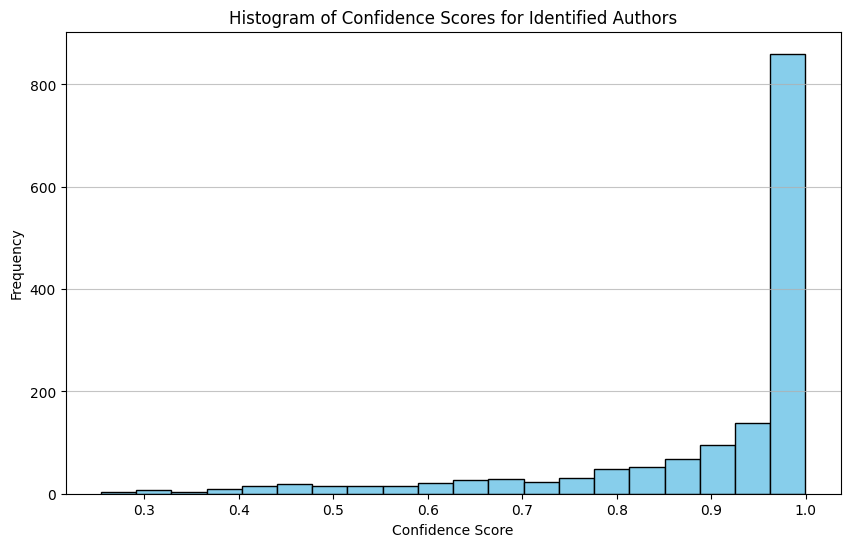

In [12]:
# This code assumes 'nlp' is your pipeline and 'merge_author_entities' is defined.
# It also assumes the data has been loaded into a pandas DataFrame `df`.
# Note: The original code loaded a 'dataset' object, so we convert it to pandas first.
df = dataset['train'].to_pandas()

# Initialize an empty list to store the confidence scores of identified authors
scores = list()

# Loop through a random sample of 100 reviews from the 'Cleaned_text' column
for review in df['Cleaned_text'].sample(100, random_state=42):
    # --- 1. Get Predictions ---
    # Get the raw results from the NER model
    raw_results = nlp(review)
    # Apply the post-processing function to merge fragmented names
    post_processed_authors = merge_author_entities(raw_results, review)

    # --- 2. Store Scores ---
    # Add all scores from the post-processed list to our main scores list
    scores.extend([item['score'] for item in post_processed_authors])

    # --- 3. Display Comparison ---
    # Use the helper function to print a side-by-side comparison
    display_comparison_flexible(
        review, 
        raw_results, 
        post_processed_authors,
        show_text=True, 
        show_ner=True, 
        show_post=True
    )

# --- 4. Plot Histogram ---
# Create a plot to visualize the distribution of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Confidence Scores for Identified Authors')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
